# Sixth Exercise (HPO)

This exercise focuses on hyperparameter optimization with neural networks.

We will
- define hyperparameter-configuration search-spaces
- train deep learning models with various hyper parameters
- use random search as a basic hyperparameter optimizer
- use BOHB as an advanced hyperparameter optimizer

It's in the nature of hyperparameter optimization, that you'll have to train a lot of models. 
Therefore execution time will be longer in this exercise, running the completed notebook takes about 30 minutes on a tutor's 3 year old laptop.

#### Install HpBandster and torchvision

You need to install two more python packages for this exercise.

- [torchvision](https://pytorch.org/docs/stable/torchvision/) provides utility methods for pytorch.
- [HpBandSter](https://github.com/automl/HpBandSter) is a fast, parallel implementation of several hyperparameter optimizers.  
   We can define even complex hyperparameter search spaces with [ConfigSpace](https://github.com/automl/ConfigSpace), which comes along HpBandSter as dependency.


Install with anaconda/conda
```
conda install torchvision
conda install hpbandster
```

or with plain python
```
pip3 install torchvision
pip3 install hpbandster
```

In [1]:
import os
from typing import Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms

import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def load_mnist_minibatched(batch_size: int, n_train: int = 8192, n_valid: int = 1024,
                           valid_test_batch_size: int = 1024) -> Tuple[DataLoader, DataLoader, DataLoader]:
    train_dataset = torchvision.datasets.MNIST(
        root='../data', train=True, transform=transforms.ToTensor(), download=True)
    test_dataset = torchvision.datasets.MNIST(
        root='../data', train=False, transform=transforms.ToTensor())

    train_sampler = SubsetRandomSampler(range(n_train))
    validation_sampler = SubsetRandomSampler(range(n_train, n_train+n_valid))

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=train_sampler)
    validation_loader = DataLoader(dataset=train_dataset, batch_size=valid_test_batch_size,
                                   sampler=validation_sampler)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=valid_test_batch_size, 
                                              shuffle=False)
    return train_loader, validation_loader, test_loader

# Added third argument: loss_fn, and return along with accuracy (by default it only returns accuracy)
def evaluate_accuracy(model: nn.Module, data_loader: DataLoader, loss_fn) -> float:
    model.eval()
    correct = 0
    loss = 0
    with torch.no_grad():
        for x, y in data_loader:
            output = model(x)
            if(loss_fn!=None):
                loss += loss_fn(output, y)
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(y.view_as(pred)).sum().item()
    accuracy = correct / len(data_loader.sampler)
    return accuracy, loss

## Random Search

Here we get hands on hyperparameter optimization using random search.

### Model and Hyperparameter Space

First we define a configurable model and a hyperparameter space. You learn how to use *ConfigSpace* to define the hyperparameters, by looking at [this example](https://automl.github.io/SMAC3/stable/quickstart.html#using-smac-in-python-svm).   

**Task:** Complete the functions as described in the docstrings.

**Hint:** The `CS.GreaterThanCondition(conditioned_hyperparameter, lefthand_side, righthand_side)` method might be useful.

In [2]:
from collections import OrderedDict

# New class added to flat inputs
class Flatten(nn.Module): 
    def forward(self, input):
        self.input_shape = input.shape
        return input.view(input.size(0), -1)

def get_conv_model(num_filters_per_layer: List[int]) -> nn.Module:
    """Builds a deep convolutional model with various number of convolution
       layers for MNIST input using pytorch.
    
    for each element in num_filters_per_layer:
        convolution (conv_kernel_size, num_filters, stride=1, padding=0)
        relu
        max pool    (pool_kernel_size, stride=1)
    linear
    log softmax
    """
    assert len(num_filters_per_layer) > 0, "len(num_filters_per_layer) should be greater than 0"
    pool_kernel_size = 2
    conv_kernel_size = 3
    
    # START TODO ################
    
    # To create a model, first we set sizes (28 x 28 pix), number of layers and input channels (greyscale)
    height = 28
    width = 28
    layer_count = len(num_filters_per_layer)
    input_channels = 1
    
    # Initialize model. Later in the for-loop we add the modules
    model  = nn.Sequential()
    
    # Iterate over the number of conv2d layers. After that always ReLU + Pooling
    for i in range(layer_count):
        
        # 1. Conv2D for each filter -> (in_channels, out_channels == number of kernels/filters, kernel_size, stride=1, padding=0)
        conv2d = nn.Conv2d(input_channels, num_filters_per_layer[i], conv_kernel_size, stride=1, padding =0)
        
        # 2. ReLU Activation function
        rel = nn.ReLU()
        
        # 3. Max pooling to reduce dimensionality and make representation more manageable
        max_pool = nn.MaxPool2d(pool_kernel_size, stride=2)
        
        # 4. Update input channels for the next layer 
        # The number of output channels (or number of kernels) of the 1st layer, will be the number of input channels of the 2nd
        input_channels = num_filters_per_layer[i]
        
        # 5. Add modules to model
        model.add_module("conv{}".format(i), conv2d)
        model.add_module("rel{}".format(i), rel)
        model.add_module("pool{}".format(i), max_pool)
        
        # 6. Update output sizes after applying convolution
        conv_height = ((height - conv_kernel_size)//1) + 1
        conv_width = ((width - conv_kernel_size))//1 + 1
        
        # 7. Update output sizes after pooling
        height = ((conv_height - pool_kernel_size))//2 + 1
        width = ((conv_width - pool_kernel_size))//2 + 1
    
    # Once we have the model created, we apply linear and softmax layers to the output for multiclass classification
    model.add_module("flat", Flatten())
    model.add_module("lin", nn.Linear(height*width*num_filters_per_layer[-1], 10))
    model.add_module("logsoftmax",nn.LogSoftmax(dim=1))
    
    return model
    # End TODO ################

def get_configspace() -> CS.ConfigurationSpace:
    """ Define a conditional hyperparameter search-space.
    
    hyperparameters:
      lr              from 1e-6 to 1e-0 (log, float)
      num_filters_1   from    2 to    8 (int)
      num_filters_2   from    2 to    8 (int)
      num_conv_layers from    1 to    2 (int)
    
    conditions: 
      include num_filters_2 only if num_conv_layers > 1
    """
    cs = CS.ConfigurationSpace()
    # START TODO ################
    
    # Hyperparameters described above
    lr = UniformFloatHyperparameter("learning_rate", 1e-6, 1e-0, default_value = 1e-2, log=True)
    num_filters_1 = UniformIntegerHyperparameter("number_filters_1", 2, 8, default_value=3)
    num_filters_2 = UniformIntegerHyperparameter("number_filters_2", 2, 8, default_value=3)
    num_conv_layers = UniformIntegerHyperparameter("number_conv2D", 1, 2, default_value=1)

    # Add hyperparameters
    cs.add_hyperparameter(lr)
    cs.add_hyperparameter(num_filters_1)
    cs.add_hyperparameters([num_conv_layers, num_filters_2])
    
    # Add conditions
    cs.add_condition(CS.GreaterThanCondition(num_filters_2, num_conv_layers, 1))

    # End TODO ################
    return cs

### Run model with configuration

A single sample from your hyperparameter space is a *Configuration*. You can use the configuration similar to a dictionary, it supports *config.keys(), config.values(), value = config[key], key in config, …* .
You can iterate a *DataLoader* to access (data, label) batches.

**Note:** If a condition isn't met, the conditional hyperparameter isn't included in the configuration.

**Task:** Complete the function to run a model like defined by the configuration. The function should return the model and the *validation error* for each epoch. You can use *evaluate_accuracy* (defined above), don't forget to switch between train and eval mode.

In [3]:
def run_conv_model(config: CS.Configuration, epochs: int, train_loader: DataLoader,
                   validation_loader: DataLoader) -> Tuple[nn.Module, List[float]]:    
    """ Run and evaluate a model from get_conv_model with NLLLoss and SGD.
    """
    # START TODO ################
    # retrieve the number of filters from the config and create the model
    
    # Save hyperparameters from the configuration space
    learning_rate = config["learning_rate"]
    num_conv_layers = config["number_conv2D"]
    num_filters =[]
    
    for i in range(num_conv_layers):
        num_filters.append(config["number_filters_{}".format(i+1)])
        
    print("[Config space] lr: {:.5f} - Number of filters: {} - Number of conv2D layers: {}".format(learning_rate, num_filters, num_conv_layers))
    model = get_conv_model(num_filters)
    
    # define loss and optimizer
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    # train the model for `epochs` and save the validation error for each epoch in   
    val_errors = []
    for epoch in range(epochs):
        for x_train, y_train in train_loader:
            model.train()
            optimizer.zero_grad()
            y_output = model(x_train)
            loss = loss_fn(y_output,y_train)
            #print(f"train loss for epoch {epoch} : {loss}")
            loss.backward()
            optimizer.step()
        
        # Evaluate on validation set 
        # Here we modified the "evaluate_accuracy" funtion to return both, loss and accuracy
        accuracy, loss = evaluate_accuracy(model, validation_loader, loss_fn)
        val_errors.append(loss)
        print("epoch #{} : accuracy = {:.5f}, loss = {:.5f}".format(epoch, accuracy, loss))
    
    # End TODO ################
    return model, val_errors

Now let's run models with various, random hyperparameter configurations. Don't forget to store all the configuration and validation errors for further evaluation.

**Tipp:** *ConfigSpace* objects have a *.sample_configuration()* function to sample a random configuration.

**Task:** Run *n_random_samples* models for *n_epochs* and store the tuple `(model, config, val_errors)` in `results`.

In [4]:
# Some imports to make it work
from ConfigSpace.hyperparameters import CategoricalHyperparameter, UniformFloatHyperparameter, UniformIntegerHyperparameter
from ConfigSpace.conditions import InCondition

n_random_samples = 18
n_epochs = 9
cs = get_configspace()
train_loader, validation_loader, _ = load_mnist_minibatched(batch_size=32, n_train=4096, n_valid=512)

# START TODO ################

results = []
for i in range(n_random_samples):
    print("Training model #{}".format(i+1))
    
    cfg = cs.sample_configuration()
    model, val_errors = run_conv_model(cfg, n_epochs, train_loader, validation_loader)
    results.append((model,cfg,val_errors))
    print("---")

# End TODO ################

Training model #1
[Config space] lr: 0.00191 - Number of filters: [8] - Number of conv2D layers: 1
epoch #0 : accuracy = 0.42383, loss = 2.22511
epoch #1 : accuracy = 0.69336, loss = 2.09693
epoch #2 : accuracy = 0.73242, loss = 1.90259
epoch #3 : accuracy = 0.76758, loss = 1.62691
epoch #4 : accuracy = 0.79492, loss = 1.32177
epoch #5 : accuracy = 0.82031, loss = 1.06312
epoch #6 : accuracy = 0.83398, loss = 0.87725
epoch #7 : accuracy = 0.84570, loss = 0.74856
epoch #8 : accuracy = 0.86133, loss = 0.66163
---
Training model #2
[Config space] lr: 0.58966 - Number of filters: [4, 6] - Number of conv2D layers: 2
epoch #0 : accuracy = 0.12500, loss = 2.29768
epoch #1 : accuracy = 0.11328, loss = 2.29829
epoch #2 : accuracy = 0.11328, loss = 2.30167
epoch #3 : accuracy = 0.12500, loss = 2.30404
epoch #4 : accuracy = 0.12500, loss = 2.29905
epoch #5 : accuracy = 0.11328, loss = 2.29952
epoch #6 : accuracy = 0.11328, loss = 2.29883
epoch #7 : accuracy = 0.11328, loss = 2.30151
epoch #8 : ac

epoch #7 : accuracy = 0.91406, loss = 0.33166
epoch #8 : accuracy = 0.91016, loss = 0.35097
---
Training model #17
[Config space] lr: 0.19950 - Number of filters: [7] - Number of conv2D layers: 1
epoch #0 : accuracy = 0.83594, loss = 0.50158
epoch #1 : accuracy = 0.89258, loss = 0.34419
epoch #2 : accuracy = 0.91992, loss = 0.29466
epoch #3 : accuracy = 0.90234, loss = 0.35588
epoch #4 : accuracy = 0.94141, loss = 0.23771
epoch #5 : accuracy = 0.93555, loss = 0.22783
epoch #6 : accuracy = 0.93945, loss = 0.23131
epoch #7 : accuracy = 0.94336, loss = 0.24009
epoch #8 : accuracy = 0.95312, loss = 0.22979
---
Training model #18
[Config space] lr: 0.00004 - Number of filters: [4, 6] - Number of conv2D layers: 2
epoch #0 : accuracy = 0.07422, loss = 2.32341
epoch #1 : accuracy = 0.07422, loss = 2.32313
epoch #2 : accuracy = 0.07422, loss = 2.32285
epoch #3 : accuracy = 0.07422, loss = 2.32258
epoch #4 : accuracy = 0.07422, loss = 2.32230
epoch #5 : accuracy = 0.07422, loss = 2.32203
epoch #

### Evaluate 

Now we should evaluate the previous runs. Evaluation in hyperparameter optimization can mean two different things: On the one hand, we might be only interested in the model with the best performance. On the other hand, we might want to find the best hyperparameter configuration to then train a model with these hyper-parameters (but with e.g. more epochs).

**Task:** Print the model and final validation error of the best model in `results`.

In [5]:
# START TODO ################

# We create a threshold that we update always being the lower found error, in order to find the minimum loss
loss_threshold = 300
best_idx = 0

for i in range(len(results)):
    model, cfg , val_error = results[i]
    if (val_error[-1] < loss_threshold):
        loss_threshold = val_error[-1]
        best_idx = i        

# best_idx contains the best result index
best_result = results[best_idx]

# Retrieve hyperparameters from best resulting config space
best_model, best_cfg, best_error = best_result
learning_rate =  best_cfg["learning_rate"]
num_conv_layers = best_cfg["number_conv2D"]
num_filters =[]

# Print Config space
print("Best model: #{}, loss : {:.5f}".format((best_idx + 1), best_error[-1]))
for i in range(num_conv_layers):
    num_filters.append(best_cfg["number_filters_{}".format(i+1)])
print("[Config space] lr: {:.5f} - Number of filters: {} - Number of conv2D layers: {}".format(learning_rate, num_filters, num_conv_layers))
print("===========================================================================================")

# We print the modules of such model
for idx, m in enumerate(best_model.named_modules()):
    if idx != 0:
        print('Module', idx, ':', m)

# END TODO ################

Best model: #11, loss : 0.19790
[Config space] lr: 0.34197 - Number of filters: [5] - Number of conv2D layers: 1
Module 1 : ('conv0', Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1)))
Module 2 : ('rel0', ReLU())
Module 3 : ('pool0', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
Module 4 : ('flat', Flatten())
Module 5 : ('lin', Linear(in_features=845, out_features=10, bias=True))
Module 6 : ('logsoftmax', LogSoftmax())


Let's further investigate which hyperparameters work well and which don't.

**Task:** Print a scatter plot of learning rate (x) and number of filters (sum over layers, y). Scale the size of the scatter points by the error in the last epoch (10 to 100).

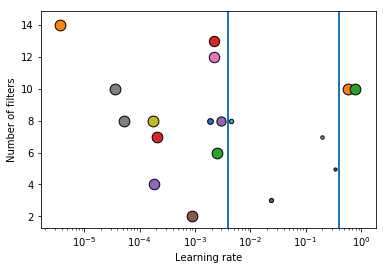

In [13]:
# START TODO ################

plt.figure(1)
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Number of filters')

for i in range(len(results)):
    model, cfg , val_error = results[i]   
    learning_rate =  cfg["learning_rate"]
    num_conv_layers = cfg["number_conv2D"]
    num_filters =[]
    for i in range(num_conv_layers):
        num_filters.append(cfg["number_filters_{}".format(i+1)])
    num_filters = np.sum(num_filters)
        
    plt.scatter(learning_rate, num_filters, s = 50*val_error[-1], edgecolors="black")
    plt.axvline(x=0.004)  
    plt.axvline(x=0.4)   
    
# END TODO ################

**Question:** What pattern do you see? Why might it occur?

**Answer:**

The bigger the point, the more error introduces such learning rate for the corresponding number of filters.
It is clear that for the lower region (learning rates lower than 10^-2), errors are ofter larger, regardless of the number of filters. Instead, in the area between both blue lines we can find the best configurations.

If we go straigh to the right, we can find as well large error configurations, probably caused by a too large learning rate which diverges and overfits, along with a too low number of filters.

After looking at the final error, let's now have a look at the training error.

**Task:** Plot error curves (error per epoch) for all your configurations in one figure.

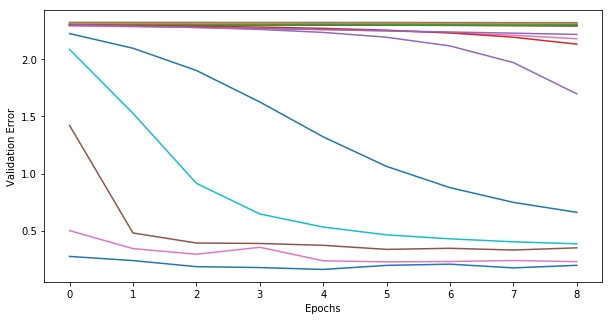

In [14]:
# START TODO ################

plt.figure(2, figsize=(10,5))
plt.xlabel('Epochs')
plt.ylabel('Validation Error')

for i in range(len(results)):
    _, _ , val_error = results[i]   
    plt.plot(val_error)
    
# END TODO ################

**Questions:** How could you detect configurations with a low error earlier/faster? Why could this be problematic? 

**Answers:**

One way would be using "early stopping", for those models which have a large validation error that does not decrease in time. We could save training time by stopping them, but it requires constant perception of the training process, or in the other hand, to set a threshold.

However, a wrong threshold could also introduces some other problems, like to stop a model, which we believe is bad, simply because the validation errors are high at the beginning. It can happen that this error decreases  quite in further epochs.

An example is in the plot itself. The <font color='blue'>blue model</font> starts having a large validation error but ends up being on of the best among others.

### Your Feedback on Exercise 6.1

I liked the practical approach of this exercise, and how to start seeing the real consequences of modifying the hyperparameters of a model.

The configuration space setup was the most difficult part for me, it was te first time I worked with it. I like also that we start working with PyTorch, I think after the "stress" of the first exercises, this makes everything a little bit easier, and additionally we can have the knowledge of an important Deep Learning framework.

This part took us around 2 days, working half-day each.

## BOHB

Here we will use the more advanced hyperparameter optimizer [BOHB](https://www.automl.org/blog_bohb/) (Bayesian Optimization with Hyperband).
Based on [Hyperband](https://arxiv.org/pdf/1603.06560.pdf), BOHB evaluates configurations on your model with increasing budgets. In the context of Deep Learning, budget can be the number of epochs or the number of training samples. In lower budget evaluations, BOHB can look at more configurations. Full budget evaluations avoid missing configurations which are poor at the beginnning but good at the end (and vice versa). 
At the start of a run, BOHB samples configurations randomly. After some time, BOHB then uses a bayesian model (based on Parzen Tree Estimators), sampling only promising configs.

This exercise part is based on the [HpBandSter Examples](https://automl.github.io/HpBandSter/build/html/auto_examples/index.html) and the [HpBandSter Documentation](https://automl.github.io/HpBandSter/). *HpBandSter* provides a fast implementation of *Randomsearch*, *Hyperband* and *BOHB*. The optimization can easily be distributed between multiple cores or even multiple computers.

In [15]:
import pickle
import logging

from hpbandster.core.worker import Worker
import hpbandster.core.nameserver as hpns
import hpbandster.core.result as hpres
from hpbandster.optimizers import BOHB

logging.getLogger('hpbandster').setLevel(logging.DEBUG)

### Implement Worker

The worker defines the hyperparameter problem which we try to optimize.
*compute(...)* should - for a given configuration and budget - return a loss which the hyperparameter optimizer tries to minimize. In our case, we can use the number of epochs as budget and the validation error as loss. 
As best practice, we define the configuration space also in the worker.

If you need help, you might get some inspiration from the [HpBandSter Pytorch Worker Example](https://automl.github.io/HpBandSter/build/html/auto_examples/example_5_pytorch_worker.html#sphx-glr-auto-examples-example-5-pytorch-worker-py).

**Task:** Complete the methods below.

In [16]:
class PyTorchWorker(Worker):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.train_loader, self.validation_loader, self.test_loader =\
            load_mnist_minibatched(batch_size=32, n_train=4096, n_valid=512)

    @staticmethod
    def get_model(config: CS.Configuration) -> nn.Module:
        """ Define a configurable convolution model.
            
        See description of get_conv_model above for more details on the model.
        """
        # START TODO ################
        #raise NotImplementedError
  
        pool_kernel_size = 2
        conv_kernel_size = 3
        height = 28
        width = 28
        
        # For each conv2D layer we save the number of kernels
        num_conv_layers = config["num_conv_layers"]
        num_filters_per_layer =[]        
        for i in range(num_conv_layers):
            num_filters_per_layer.append(config["num_filters_{}".format(i+1)])
        
        # This part is exactly like the first one, to create the model with the modules
        
        # Initialize model. Later in the for-loop we add the modules
        model  = nn.Sequential()
        input_channels = 1

        # Iterate over the number of conv2d layers. After that always ReLU + Pooling
        for i in range(num_conv_layers):
            
            # 1. Conv2D for each filter -> (in_channels, out_channels == number of kernels/filters, kernel_size, stride=1, padding=0)
            conv2d = nn.Conv2d(input_channels, num_filters_per_layer[i], conv_kernel_size, stride=1, padding =0)            
            
            # 2. ReLU Activation function
            rel = nn.ReLU()
            
            # 3. Max pooling to reduce dimensionality and make representation more manageable
            max_pool = nn.MaxPool2d(pool_kernel_size, stride=2)            
            
            # 4. Update input channels for the next layer 
            # The number of output channels (or number of kernels) of the 1st layer, will be the number of input channels of the 2nd
            input_channels = num_filters_per_layer[i]            
            
            # 5. Add modules to model
            model.add_module("conv{}".format(i), conv2d)
            model.add_module("rel{}".format(i), rel)
            model.add_module("pool{}".format(i), max_pool)
            
            # 6. Update output sizes after applying convolution
            conv_height = ((height - conv_kernel_size)//1) + 1
            conv_width = ((width - conv_kernel_size))//1 + 1
        
            # 7. Update output sizes after pooling
            height = ((conv_height - pool_kernel_size))//2 + 1
            width = ((conv_width - pool_kernel_size))//2 + 1
            
        # Once we have the model created, we apply linear and softmax layers to the output for multiclass classification
        model.add_module("flat", Flatten())
        model.add_module("lin", nn.Linear(height*width*num_filters_per_layer[-1], 10))
        model.add_module("logsoftmax",nn.LogSoftmax(dim=1))
        
        return model  
    
        # END TODO ################
        
    @staticmethod
    def get_configspace() -> CS.Configuration:
        """ Define a conditional hyperparameter search-space.
    
        hyperparameters:
          num_filters_1   from    4 to   32 (int)
          num_filters_2   from    4 to   32 (int)
          num_filters_3   from    4 to   32 (int)
          num_conv_layers from    1 to    3 (int)
          lr              from 1e-6 to 1e-1 (float, log)
          sgd_momentum    from 0.00 to 0.99 (float)
          optimizer            Adam or  SGD (categoric)
          
        conditions: 
          include num_filters_2 only if num_conv_layers > 1
          include num_filters_3 only if num_conv_layers > 2
          include sgd_momentum  only if       optimizer = SGD
        """
        # START TODO ################
        #raise NotImplementedError
        
        # Also, like in the first part, we create the hyperparameters and Config space
        cs = CS.ConfigurationSpace()
        
        # Learning rate
        lr = UniformFloatHyperparameter("lr", 1e-6, 1e-1, default_value = 1e-2, log=True)
        
        # Optimizer hyperparameters
        momentum = UniformFloatHyperparameter("cs_momentum", 0, 0.99, default_value = 0.5)
        optimizer = CategoricalHyperparameter("cs_optimizer", ["Adam","SGD"], default_value="SGD")
        
        # Conv2D hyperparameters
        num_conv_layers = UniformIntegerHyperparameter("num_conv_layers", 1, 3, default_value=2)
        num_filters_1 = UniformIntegerHyperparameter("num_filters_1", 4, 32, default_value=6)
        num_filters_2 = UniformIntegerHyperparameter("num_filters_2", 4, 32, default_value=6)
        num_filters_3 = UniformIntegerHyperparameter("num_filters_3", 4, 32, default_value=6)
        
        # Adding hyperparameters
        cs.add_hyperparameter(lr)      
        cs.add_hyperparameters([optimizer, momentum])
        cs.add_hyperparameters([num_conv_layers, num_filters_1, num_filters_2, num_filters_3])

        # Adding conditions
        cs.add_condition(InCondition(child=momentum, parent=optimizer, values=["SGD"])) # <- Belongs to Optimizer
        cs.add_condition(CS.GreaterThanCondition(num_filters_2, num_conv_layers, 1))
        cs.add_condition(CS.GreaterThanCondition(num_filters_3, num_conv_layers, 2))
        
        return cs

        # END TODO ################

    def compute(self, config: CS.Configuration, budget: float, working_directory: str,
                *args, **kwargs) -> float:
        """Evaluate a function with the given config and budget and return a loss.
        
        Bohb tries to minimize the returned loss.
        
        In our case the function is the training and validation of a model,
        the budget is the number of epochs and the loss is the validation error.
        """
        model = self.get_model(config)
        
        # START TODO ################
        
        learning_rate = config["lr"]
        opt = config["cs_optimizer"]
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        if(opt == "SGD"):
            momentum = config["cs_momentum"]
            optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum)
        loss_fn = torch.nn.NLLLoss()
        
        # We start training here
        epochs = int(budget)
        for epoch in range(epochs):
            for x_train, y_train in self.train_loader:
                model.train()
                optimizer.zero_grad()
                y_output = model(x_train)
                loss = loss_fn(y_output, y_train)
                loss.backward()
                optimizer.step() 

        # END TODO ################
        
        train_accuracy, _ = evaluate_accuracy(model, self.train_loader, None)
        validation_accuracy, _ = evaluate_accuracy(model, self.validation_loader, None)
        test_accuracy, _ = evaluate_accuracy(model, self.test_loader, None)
        
        return ({
                'loss': 1 - validation_accuracy,  # remember: HpBandSter minimizes the loss!
                'info': {'test_accuracy': test_accuracy,
                         'train_accuracy': train_accuracy,
                         'valid_accuracy': validation_accuracy,
                         'model': str(model)}
                })

   

It's best practice to do a quick sanity check of our worker with a low budget:

In [17]:
working_dir = os.curdir
# minimum budget that BOHB uses
min_budget = 1
# largest budget BOHB will use
max_budget = 9

In [18]:
worker = PyTorchWorker(run_id='0')
cs = worker.get_configspace()

config = cs.sample_configuration().get_dictionary()
print(config)

res = worker.compute(config=config, budget=min_budget, working_directory=working_dir)
print(res)

{'num_filters_2': 9, 'cs_optimizer': 'Adam', 'num_filters_3': 20, 'num_filters_1': 14, 'lr': 6.965447440594796e-05, 'num_conv_layers': 3}
{'info': {'test_accuracy': 0.1007, 'train_accuracy': 0.09765625, 'valid_accuracy': 0.109375, 'model': 'Sequential(\n  (conv0): Conv2d(1, 14, kernel_size=(3, 3), stride=(1, 1))\n  (rel0): ReLU()\n  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (conv1): Conv2d(14, 9, kernel_size=(3, 3), stride=(1, 1))\n  (rel1): ReLU()\n  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (conv2): Conv2d(9, 20, kernel_size=(3, 3), stride=(1, 1))\n  (rel2): ReLU()\n  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (flat): Flatten()\n  (lin): Linear(in_features=20, out_features=10, bias=True)\n  (logsoftmax): LogSoftmax()\n)'}, 'loss': 0.890625}


### Run BOHB

We now run the hyperparameter search with BOHB and the worker which we defined above and save the result to disk. 
Try to understand what happens. *HpBandSter* allows to start additional workers on the same or remote devices to parallelize the executions, that's why we need to setup some network stuff (nameserver, nic, host, port, …). If you're interested, you can check this out in the [HpBandSter Examples](https://automl.github.io/HpBandSter/build/html/auto_examples/index.html), but it is beyond the scope of this exercise.

**Note:** The code below will try 60 different configurations. Some of them are executed at multiple budgets, which results in about 80 model training. Therefore it might take a while (15-45 minutes on a laptop). If you are interested in how BOHB works, checkout [BOHB (Falkner et al. 2018)](http://proceedings.mlr.press/v80/falkner18a.html).

**Note 2:** You can see the progress in the debug output below. The configuration identifier (called `config_id` in the docs) is a three-tuple `(current iteration, resampling in case of error, sample)`. 

In [19]:
result_file = os.path.join(working_dir, 'bohb_result.pkl')
nic_name = 'lo'
port = 0
run_id = 'bohb_run_1'
n_bohb_iterations = 12

In [20]:
try:
    # Start a nameserver
    host = hpns.nic_name_to_host(nic_name)
    ns = hpns.NameServer(run_id=run_id, host=host, port=port,
                         working_directory=working_dir)
    ns_host, ns_port = ns.start()

    # Start local worker
    w = PyTorchWorker(run_id=run_id, host=host, nameserver=ns_host,
                      nameserver_port=ns_port, timeout=120)
    w.run(background=True)

    # Run an optimizer
    bohb = BOHB(configspace=worker.get_configspace(),
                run_id=run_id,
                host=host,
                nameserver=ns_host,
                nameserver_port=ns_port,
                min_budget=min_budget, max_budget=max_budget)
    
    result = bohb.run(n_iterations=n_bohb_iterations)
    print("Write result to file {}".format(result_file))
    with open(result_file, 'wb') as f:
        pickle.dump(result, f)
finally:
    bohb.shutdown(shutdown_workers=True)
    ns.shutdown()

17:07:31 wait_for_workers trying to get the condition
17:07:31 WORKER: Connected to nameserver <Pyro4.core.Proxy at 0x7fc978a74518; connected IPv4; for PYRO:Pyro.NameServer@127.0.0.1:43023>
17:07:31 DISPATCHER: started the 'discover_worker' thread
17:07:31 WORKER: No dispatcher found. Waiting for one to initiate contact.
17:07:31 DISPATCHER: started the 'job_runner' thread
17:07:31 WORKER: start listening for jobs
17:07:31 DISPATCHER: Pyro daemon running on 127.0.0.1:43237
17:07:31 DISPATCHER: Starting worker discovery
17:07:31 DISPATCHER: Found 1 potential workers, 0 currently in the pool.
17:07:31 DISPATCHER: discovered new worker, hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184
17:07:31 HBMASTER: number of workers changed to 1
17:07:31 Enough workers to start this run!
17:07:31 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
17:07:31 adjust_queue_size: lock accquired
17:07:31 HBMASTER: starting run at 1543766851.9366667
17:07:31 HBMAST

17:07:40 job_id: (0, 0, 2)
kwargs: {'budget': 1.0, 'config': {'num_filters_2': 18, 'num_conv_layers': 2, 'num_filters_1': 5, 'lr': 0.002342517850671262, 'cs_optimizer': 'Adam'}, 'working_directory': '.'}
result: {'info': {'test_accuracy': 0.8847, 'train_accuracy': 0.8974609375, 'valid_accuracy': 0.900390625, 'model': 'Sequential(\n  (conv0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))\n  (rel0): ReLU()\n  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (conv1): Conv2d(5, 18, kernel_size=(3, 3), stride=(1, 1))\n  (rel1): ReLU()\n  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (flat): Flatten()\n  (lin): Linear(in_features=450, out_features=10, bias=True)\n  (logsoftmax): LogSoftmax()\n)'}, 'loss': 0.099609375}
exception: None

17:07:40 job_callback for (0, 0, 2) started
17:07:40 DISPATCHER: Trying to submit another job.
17:07:40 job_callback for (0, 0, 2) got condition
17:07:40 DISPATCHER: jobs to submit

17:07:50 DISPATCHER: job (0, 0, 5) finished
17:07:50 DISPATCHER: register_result: lock acquired
17:07:50 DISPATCHER: job (0, 0, 5) on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184 finished
17:07:50 job_id: (0, 0, 5)
kwargs: {'budget': 1.0, 'config': {'num_conv_layers': 1, 'num_filters_1': 11, 'lr': 3.931959776435283e-05, 'cs_optimizer': 'Adam'}, 'working_directory': '.'}
result: {'info': {'test_accuracy': 0.5228, 'train_accuracy': 0.533203125, 'valid_accuracy': 0.552734375, 'model': 'Sequential(\n  (conv0): Conv2d(1, 11, kernel_size=(3, 3), stride=(1, 1))\n  (rel0): ReLU()\n  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (flat): Flatten()\n  (lin): Linear(in_features=1859, out_features=10, bias=True)\n  (logsoftmax): LogSoftmax()\n)'}, 'loss': 0.447265625}
exception: None

17:07:50 job_callback for (0, 0, 5) started
17:07:50 DISPATCHER: Trying to submit another job.
17:07:50 job_callback for (0, 0, 5) got condition
17:

17:08:02 job_callback for (0, 0, 8) started
17:08:02 DISPATCHER: Trying to submit another job.
17:08:02 job_callback for (0, 0, 8) got condition
17:08:02 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
17:08:02 HBMASTER: Trying to run another job!
17:08:02 job_callback for (0, 0, 8) finished
17:08:02 ITERATION: Advancing config (0, 0, 0) to next budget 3.000000
17:08:02 ITERATION: Advancing config (0, 0, 2) to next budget 3.000000
17:08:02 ITERATION: Advancing config (0, 0, 4) to next budget 3.000000
17:08:02 HBMASTER: schedule new run for iteration 0
17:08:02 HBMASTER: trying submitting job (0, 0, 0) to dispatcher
17:08:02 HBMASTER: submitting job (0, 0, 0) to dispatcher
17:08:02 DISPATCHER: trying to submit job (0, 0, 0)
17:08:02 DISPATCHER: trying to notify the job_runner thread.
17:08:02 HBMASTER: job (0, 0, 0) submitted to dispatcher
17:08:02 DISPATCHER: Trying to submit another job.
17:08:02 HBMASTER: running jobs: 1, queue sizes: (0, 1) -> wait
17:08:02 DI

17:08:16 HBMASTER: Trying to run another job!
17:08:16 job_callback for (0, 0, 4) finished
17:08:16 ITERATION: Advancing config (0, 0, 0) to next budget 9.000000
17:08:16 HBMASTER: schedule new run for iteration 0
17:08:16 HBMASTER: trying submitting job (0, 0, 0) to dispatcher
17:08:16 HBMASTER: submitting job (0, 0, 0) to dispatcher
17:08:16 DISPATCHER: trying to submit job (0, 0, 0)
17:08:16 DISPATCHER: trying to notify the job_runner thread.
17:08:16 HBMASTER: job (0, 0, 0) submitted to dispatcher
17:08:16 DISPATCHER: Trying to submit another job.
17:08:16 HBMASTER: running jobs: 1, queue sizes: (0, 1) -> wait
17:08:16 DISPATCHER: starting job (0, 0, 0) on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184
17:08:16 DISPATCHER: job (0, 0, 0) dispatched on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184
17:08:16 WORKER: start processing job (0, 0, 0)
17:08:16 DISPATCHER: jobs to submit = 0, number of idle workers = 0 -> waiting!
17:08:16

17:08:34 start sampling a new configuration.
17:08:34 done sampling a new configuration.
17:08:34 HBMASTER: schedule new run for iteration 1
17:08:34 HBMASTER: trying submitting job (1, 0, 2) to dispatcher
17:08:34 HBMASTER: submitting job (1, 0, 2) to dispatcher
17:08:34 DISPATCHER: trying to submit job (1, 0, 2)
17:08:34 DISPATCHER: trying to notify the job_runner thread.
17:08:34 HBMASTER: job (1, 0, 2) submitted to dispatcher
17:08:34 DISPATCHER: Trying to submit another job.
17:08:34 HBMASTER: running jobs: 1, queue sizes: (0, 1) -> wait
17:08:34 DISPATCHER: starting job (1, 0, 2) on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184
17:08:34 DISPATCHER: job (1, 0, 2) dispatched on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184
17:08:34 DISPATCHER: jobs to submit = 0, number of idle workers = 0 -> waiting!
17:08:34 WORKER: start processing job (1, 0, 2)
17:08:34 WORKER: args: ()
17:08:34 WORKER: kwargs: {'budget': 3.0, 'config': {'cs

17:09:16 job_callback for (2, 0, 0) started
17:09:16 DISPATCHER: Trying to submit another job.
17:09:16 job_callback for (2, 0, 0) got condition
17:09:16 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
17:09:16 Only 3 run(s) for budget 9.000000 available, need more than 9 -> can't build model!
17:09:16 HBMASTER: Trying to run another job!
17:09:16 job_callback for (2, 0, 0) finished
17:09:16 start sampling a new configuration.
17:09:16 done sampling a new configuration.
17:09:16 HBMASTER: schedule new run for iteration 2
17:09:16 HBMASTER: trying submitting job (2, 0, 1) to dispatcher
17:09:16 HBMASTER: submitting job (2, 0, 1) to dispatcher
17:09:16 DISPATCHER: trying to submit job (2, 0, 1)
17:09:16 DISPATCHER: trying to notify the job_runner thread.
17:09:16 HBMASTER: job (2, 0, 1) submitted to dispatcher
17:09:16 DISPATCHER: Trying to submit another job.
17:09:16 HBMASTER: running jobs: 1, queue sizes: (0, 1) -> wait
17:09:16 DISPATCHER: starting job (2, 0, 1

17:09:43 job_callback for (3, 0, 0) started
17:09:43 DISPATCHER: Trying to submit another job.
17:09:43 job_callback for (3, 0, 0) got condition
17:09:43 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
17:09:43 HBMASTER: Trying to run another job!
17:09:43 job_callback for (3, 0, 0) finished
17:09:43 start sampling a new configuration.
17:09:43 done sampling a new configuration.
17:09:43 HBMASTER: schedule new run for iteration 3
17:09:43 HBMASTER: trying submitting job (3, 0, 1) to dispatcher
17:09:43 HBMASTER: submitting job (3, 0, 1) to dispatcher
17:09:43 DISPATCHER: trying to submit job (3, 0, 1)
17:09:43 DISPATCHER: trying to notify the job_runner thread.
17:09:43 HBMASTER: job (3, 0, 1) submitted to dispatcher
17:09:43 DISPATCHER: Trying to submit another job.
17:09:43 HBMASTER: running jobs: 1, queue sizes: (0, 1) -> wait
17:09:43 DISPATCHER: starting job (3, 0, 1) on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184
17:09:43 DISPAT

17:09:50 DISPATCHER: trying to notify the job_runner thread.
17:09:50 HBMASTER: job (3, 0, 4) submitted to dispatcher
17:09:50 DISPATCHER: Trying to submit another job.
17:09:50 HBMASTER: running jobs: 1, queue sizes: (0, 1) -> wait
17:09:50 DISPATCHER: starting job (3, 0, 4) on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184
17:09:50 DISPATCHER: job (3, 0, 4) dispatched on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184
17:09:50 WORKER: start processing job (3, 0, 4)
17:09:50 DISPATCHER: jobs to submit = 0, number of idle workers = 0 -> waiting!
17:09:50 WORKER: args: ()
17:09:50 WORKER: kwargs: {'budget': 1.0, 'config': {'cs_momentum': 0.3940121912112679, 'num_filters_2': 14, 'cs_optimizer': 'SGD', 'num_filters_3': 21, 'num_filters_1': 20, 'lr': 5.035303892650715e-05, 'num_conv_layers': 3}, 'working_directory': '.'}
17:09:53 WORKER: done with job (3, 0, 4), trying to register it.
17:09:53 WORKER: registered result for job (3, 0, 4) wi

17:09:57 HBMASTER: job (3, 0, 7) submitted to dispatcher
17:09:57 DISPATCHER: Trying to submit another job.
17:09:57 HBMASTER: running jobs: 1, queue sizes: (0, 1) -> wait
17:09:57 DISPATCHER: starting job (3, 0, 7) on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184
17:09:57 DISPATCHER: job (3, 0, 7) dispatched on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184
17:09:57 DISPATCHER: jobs to submit = 0, number of idle workers = 0 -> waiting!
17:09:57 WORKER: start processing job (3, 0, 7)
17:09:57 WORKER: args: ()
17:09:57 WORKER: kwargs: {'budget': 1.0, 'config': {'cs_momentum': 0.1324607765447045, 'num_filters_2': 24, 'cs_optimizer': 'SGD', 'num_filters_3': 28, 'num_filters_1': 15, 'lr': 0.023764243496840972, 'num_conv_layers': 3}, 'working_directory': '.'}
17:10:00 WORKER: done with job (3, 0, 7), trying to register it.
17:10:00 WORKER: registered result for job (3, 0, 7) with dispatcher
17:10:00 DISPATCHER: job (3, 0, 7) finished
17:1

17:10:07 HBMASTER: running jobs: 1, queue sizes: (0, 1) -> wait
17:10:07 DISPATCHER: starting job (3, 0, 5) on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184
17:10:07 DISPATCHER: job (3, 0, 5) dispatched on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184
17:10:07 WORKER: start processing job (3, 0, 5)
17:10:07 DISPATCHER: jobs to submit = 0, number of idle workers = 0 -> waiting!
17:10:07 WORKER: args: ()
17:10:07 WORKER: kwargs: {'budget': 3.0, 'config': {'num_conv_layers': 1, 'num_filters_1': 7, 'lr': 0.00013403739401304687, 'cs_optimizer': 'Adam'}, 'working_directory': '.'}
17:10:09 WORKER: done with job (3, 0, 5), trying to register it.
17:10:09 WORKER: registered result for job (3, 0, 5) with dispatcher
17:10:09 DISPATCHER: job (3, 0, 5) finished
17:10:09 DISPATCHER: register_result: lock acquired
17:10:09 DISPATCHER: job (3, 0, 5) on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184 finished
17:10:09 job_id

17:10:25 DISPATCHER: register_result: lock acquired
17:10:25 DISPATCHER: job (4, 0, 0) on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184 finished
17:10:25 job_id: (4, 0, 0)
kwargs: {'budget': 3.0, 'config': {'num_filters_2': 13, 'cs_optimizer': 'Adam', 'num_filters_3': 26, 'num_filters_1': 21, 'lr': 0.009035138803407557, 'num_conv_layers': 3}, 'working_directory': '.'}
result: {'info': {'test_accuracy': 0.9148, 'train_accuracy': 0.9267578125, 'valid_accuracy': 0.9296875, 'model': 'Sequential(\n  (conv0): Conv2d(1, 21, kernel_size=(3, 3), stride=(1, 1))\n  (rel0): ReLU()\n  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (conv1): Conv2d(21, 13, kernel_size=(3, 3), stride=(1, 1))\n  (rel1): ReLU()\n  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (conv2): Conv2d(13, 26, kernel_size=(3, 3), stride=(1, 1))\n  (rel2): ReLU()\n  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

17:10:44 DISPATCHER: job (4, 0, 0) finished
17:10:44 DISPATCHER: register_result: lock acquired
17:10:44 DISPATCHER: job (4, 0, 0) on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184 finished
17:10:44 job_id: (4, 0, 0)
kwargs: {'budget': 9.0, 'config': {'num_filters_2': 13, 'cs_optimizer': 'Adam', 'num_filters_3': 26, 'num_filters_1': 21, 'lr': 0.009035138803407557, 'num_conv_layers': 3}, 'working_directory': '.'}
result: {'info': {'test_accuracy': 0.9395, 'train_accuracy': 0.97119140625, 'valid_accuracy': 0.9296875, 'model': 'Sequential(\n  (conv0): Conv2d(1, 21, kernel_size=(3, 3), stride=(1, 1))\n  (rel0): ReLU()\n  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (conv1): Conv2d(21, 13, kernel_size=(3, 3), stride=(1, 1))\n  (rel1): ReLU()\n  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (conv2): Conv2d(13, 26, kernel_size=(3, 3), stride=(1, 1))\n  (rel2): ReLU()\n  (pool2): MaxPoo

17:11:10 DISPATCHER: register_result: lock acquired
17:11:10 DISPATCHER: job (5, 0, 2) on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184 finished
17:11:10 job_id: (5, 0, 2)
kwargs: {'budget': 9.0, 'config': {'num_conv_layers': 1, 'num_filters_1': 17, 'lr': 0.0509420320934846, 'cs_optimizer': 'Adam'}, 'working_directory': '.'}
result: {'info': {'test_accuracy': 0.9235, 'train_accuracy': 0.98291015625, 'valid_accuracy': 0.9296875, 'model': 'Sequential(\n  (conv0): Conv2d(1, 17, kernel_size=(3, 3), stride=(1, 1))\n  (rel0): ReLU()\n  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (flat): Flatten()\n  (lin): Linear(in_features=2873, out_features=10, bias=True)\n  (logsoftmax): LogSoftmax()\n)'}, 'loss': 0.0703125}
exception: None

17:11:10 job_callback for (5, 0, 2) started
17:11:10 DISPATCHER: Trying to submit another job.
17:11:10 job_callback for (5, 0, 2) got condition
17:11:10 DISPATCHER: jobs to submit = 0, number of i

17:11:17 DISPATCHER: job (6, 0, 2) on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184 finished
17:11:17 job_id: (6, 0, 2)
kwargs: {'budget': 1.0, 'config': {'num_filters_2': 21, 'num_conv_layers': 2, 'num_filters_1': 9, 'lr': 0.07807904679337195, 'cs_optimizer': 'Adam'}, 'working_directory': '.'}
result: {'info': {'test_accuracy': 0.1135, 'train_accuracy': 0.111328125, 'valid_accuracy': 0.11328125, 'model': 'Sequential(\n  (conv0): Conv2d(1, 9, kernel_size=(3, 3), stride=(1, 1))\n  (rel0): ReLU()\n  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (conv1): Conv2d(9, 21, kernel_size=(3, 3), stride=(1, 1))\n  (rel1): ReLU()\n  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (flat): Flatten()\n  (lin): Linear(in_features=525, out_features=10, bias=True)\n  (logsoftmax): LogSoftmax()\n)'}, 'loss': 0.88671875}
exception: None

17:11:17 job_callback for (6, 0, 2) started
17:11:17 DISPATCHER:

17:11:25 WORKER: done with job (6, 0, 5), trying to register it.
17:11:25 WORKER: registered result for job (6, 0, 5) with dispatcher
17:11:25 DISPATCHER: job (6, 0, 5) finished
17:11:25 DISPATCHER: register_result: lock acquired
17:11:25 DISPATCHER: job (6, 0, 5) on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184 finished
17:11:25 job_id: (6, 0, 5)
kwargs: {'budget': 1.0, 'config': {'num_conv_layers': 1, 'num_filters_1': 29, 'lr': 0.08363827852589481, 'cs_optimizer': 'Adam'}, 'working_directory': '.'}
result: {'info': {'test_accuracy': 0.8857, 'train_accuracy': 0.9287109375, 'valid_accuracy': 0.91015625, 'model': 'Sequential(\n  (conv0): Conv2d(1, 29, kernel_size=(3, 3), stride=(1, 1))\n  (rel0): ReLU()\n  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (flat): Flatten()\n  (lin): Linear(in_features=4901, out_features=10, bias=True)\n  (logsoftmax): LogSoftmax()\n)'}, 'loss': 0.08984375}
exception: None

17:11:25 job_call

17:11:30 WORKER: start processing job (6, 0, 8)
17:11:30 WORKER: args: ()
17:11:30 WORKER: kwargs: {'budget': 1.0, 'config': {'num_conv_layers': 1, 'num_filters_1': 27, 'lr': 0.04500704124831436, 'cs_optimizer': 'Adam'}, 'working_directory': '.'}
17:11:31 DISPATCHER: Starting worker discovery
17:11:31 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
17:11:31 DISPATCHER: Finished worker discovery
17:11:33 WORKER: done with job (6, 0, 8), trying to register it.
17:11:33 WORKER: registered result for job (6, 0, 8) with dispatcher
17:11:33 DISPATCHER: job (6, 0, 8) finished
17:11:33 DISPATCHER: register_result: lock acquired
17:11:33 DISPATCHER: job (6, 0, 8) on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184 finished
17:11:33 job_id: (6, 0, 8)
kwargs: {'budget': 1.0, 'config': {'num_conv_layers': 1, 'num_filters_1': 27, 'lr': 0.04500704124831436, 'cs_optimizer': 'Adam'}, 'working_directory': '.'}
result: {'info': {'test_accuracy': 0.9144, 'train_acc

17:11:46 job_callback for (6, 0, 4) started
17:11:46 DISPATCHER: Trying to submit another job.
17:11:46 job_callback for (6, 0, 4) got condition
17:11:46 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
17:11:46 HBMASTER: Trying to run another job!
17:11:46 job_callback for (6, 0, 4) finished
17:11:46 ITERATION: Advancing config (6, 0, 4) to next budget 9.000000
17:11:46 HBMASTER: schedule new run for iteration 6
17:11:46 HBMASTER: trying submitting job (6, 0, 4) to dispatcher
17:11:46 HBMASTER: submitting job (6, 0, 4) to dispatcher
17:11:46 DISPATCHER: trying to submit job (6, 0, 4)
17:11:46 DISPATCHER: trying to notify the job_runner thread.
17:11:46 HBMASTER: job (6, 0, 4) submitted to dispatcher
17:11:46 DISPATCHER: Trying to submit another job.
17:11:46 HBMASTER: running jobs: 1, queue sizes: (0, 1) -> wait
17:11:46 DISPATCHER: starting job (6, 0, 4) on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184
17:11:46 DISPATCHER: job (6, 0, 4

17:12:06 done sampling a new configuration.
17:12:06 HBMASTER: schedule new run for iteration 7
17:12:06 HBMASTER: trying submitting job (7, 0, 2) to dispatcher
17:12:06 HBMASTER: submitting job (7, 0, 2) to dispatcher
17:12:06 DISPATCHER: trying to submit job (7, 0, 2)
17:12:06 DISPATCHER: trying to notify the job_runner thread.
17:12:06 HBMASTER: job (7, 0, 2) submitted to dispatcher
17:12:06 DISPATCHER: Trying to submit another job.
17:12:06 HBMASTER: running jobs: 1, queue sizes: (0, 1) -> wait
17:12:06 DISPATCHER: starting job (7, 0, 2) on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184
17:12:06 DISPATCHER: job (7, 0, 2) dispatched on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184
17:12:06 WORKER: start processing job (7, 0, 2)
17:12:06 DISPATCHER: jobs to submit = 0, number of idle workers = 0 -> waiting!
17:12:06 WORKER: args: ()
17:12:06 WORKER: kwargs: {'budget': 3.0, 'config': {'num_conv_layers': 1, 'num_filters_1': 20, 'lr':

17:12:35 done sampling a new configuration.
17:12:35 HBMASTER: schedule new run for iteration 8
17:12:35 HBMASTER: trying submitting job (8, 0, 1) to dispatcher
17:12:35 HBMASTER: submitting job (8, 0, 1) to dispatcher
17:12:35 DISPATCHER: trying to submit job (8, 0, 1)
17:12:35 DISPATCHER: trying to notify the job_runner thread.
17:12:35 HBMASTER: job (8, 0, 1) submitted to dispatcher
17:12:35 DISPATCHER: Trying to submit another job.
17:12:35 HBMASTER: running jobs: 1, queue sizes: (0, 1) -> wait
17:12:35 DISPATCHER: starting job (8, 0, 1) on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184
17:12:35 DISPATCHER: job (8, 0, 1) dispatched on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184
17:12:35 WORKER: start processing job (8, 0, 1)
17:12:35 DISPATCHER: jobs to submit = 0, number of idle workers = 0 -> waiting!
17:12:35 WORKER: args: ()
17:12:35 WORKER: kwargs: {'budget': 9.0, 'config': {'cs_momentum': 0.4998939207857246, 'num_conv_lay

17:12:55 DISPATCHER: starting job (9, 0, 1) on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184
17:12:55 DISPATCHER: job (9, 0, 1) dispatched on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184
17:12:55 DISPATCHER: jobs to submit = 0, number of idle workers = 0 -> waiting!
17:12:55 WORKER: start processing job (9, 0, 1)
17:12:55 WORKER: args: ()
17:12:55 WORKER: kwargs: {'budget': 1.0, 'config': {'num_filters_2': 9, 'num_conv_layers': 2, 'num_filters_1': 16, 'lr': 0.004636210536688264, 'cs_optimizer': 'Adam'}, 'working_directory': '.'}
17:12:57 WORKER: done with job (9, 0, 1), trying to register it.
17:12:57 WORKER: registered result for job (9, 0, 1) with dispatcher
17:12:57 DISPATCHER: job (9, 0, 1) finished
17:12:57 DISPATCHER: register_result: lock acquired
17:12:57 DISPATCHER: job (9, 0, 1) on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184 finished
17:12:57 job_id: (9, 0, 1)
kwargs: {'budget': 1.0, 'config':

17:13:02 DISPATCHER: jobs to submit = 0, number of idle workers = 0 -> waiting!
17:13:02 WORKER: args: ()
17:13:02 WORKER: kwargs: {'budget': 1.0, 'config': {'num_filters_2': 13, 'num_conv_layers': 2, 'num_filters_1': 24, 'lr': 1.3047322100124752e-06, 'cs_optimizer': 'Adam'}, 'working_directory': '.'}
17:13:06 WORKER: done with job (9, 0, 4), trying to register it.
17:13:06 WORKER: registered result for job (9, 0, 4) with dispatcher
17:13:06 DISPATCHER: job (9, 0, 4) finished
17:13:06 DISPATCHER: register_result: lock acquired
17:13:06 DISPATCHER: job (9, 0, 4) on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184 finished
17:13:06 job_id: (9, 0, 4)
kwargs: {'budget': 1.0, 'config': {'num_filters_2': 13, 'num_conv_layers': 2, 'num_filters_1': 24, 'lr': 1.3047322100124752e-06, 'cs_optimizer': 'Adam'}, 'working_directory': '.'}
result: {'info': {'test_accuracy': 0.1218, 'train_accuracy': 0.13720703125, 'valid_accuracy': 0.140625, 'model': 'Sequential(\n  (conv0): Co

17:13:10 WORKER: args: ()
17:13:10 WORKER: kwargs: {'budget': 1.0, 'config': {'num_filters_2': 20, 'num_conv_layers': 2, 'num_filters_1': 22, 'lr': 0.00038189609559987166, 'cs_optimizer': 'Adam'}, 'working_directory': '.'}
17:13:13 WORKER: done with job (9, 0, 7), trying to register it.
17:13:13 WORKER: registered result for job (9, 0, 7) with dispatcher
17:13:13 DISPATCHER: job (9, 0, 7) finished
17:13:13 DISPATCHER: register_result: lock acquired
17:13:13 DISPATCHER: job (9, 0, 7) on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184 finished
17:13:13 job_id: (9, 0, 7)
kwargs: {'budget': 1.0, 'config': {'num_filters_2': 20, 'num_conv_layers': 2, 'num_filters_1': 22, 'lr': 0.00038189609559987166, 'cs_optimizer': 'Adam'}, 'working_directory': '.'}
result: {'info': {'test_accuracy': 0.8017, 'train_accuracy': 0.80859375, 'valid_accuracy': 0.82421875, 'model': 'Sequential(\n  (conv0): Conv2d(1, 22, kernel_size=(3, 3), stride=(1, 1))\n  (rel0): ReLU()\n  (pool0): MaxP

17:13:24 WORKER: done with job (9, 0, 1), trying to register it.
17:13:24 WORKER: registered result for job (9, 0, 1) with dispatcher
17:13:24 DISPATCHER: job (9, 0, 1) finished
17:13:24 DISPATCHER: register_result: lock acquired
17:13:24 DISPATCHER: job (9, 0, 1) on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184 finished
17:13:24 job_id: (9, 0, 1)
kwargs: {'budget': 3.0, 'config': {'num_filters_2': 9, 'num_conv_layers': 2, 'num_filters_1': 16, 'lr': 0.004636210536688264, 'cs_optimizer': 'Adam'}, 'working_directory': '.'}
result: {'info': {'test_accuracy': 0.9517, 'train_accuracy': 0.966796875, 'valid_accuracy': 0.953125, 'model': 'Sequential(\n  (conv0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))\n  (rel0): ReLU()\n  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (conv1): Conv2d(16, 9, kernel_size=(3, 3), stride=(1, 1))\n  (rel1): ReLU()\n  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mo

17:13:43 WORKER: done with job (10, 0, 0), trying to register it.
17:13:43 WORKER: registered result for job (10, 0, 0) with dispatcher
17:13:43 DISPATCHER: job (10, 0, 0) finished
17:13:43 DISPATCHER: register_result: lock acquired
17:13:43 DISPATCHER: job (10, 0, 0) on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184 finished
17:13:43 job_id: (10, 0, 0)
kwargs: {'budget': 3.0, 'config': {'num_filters_2': 21, 'cs_optimizer': 'Adam', 'num_filters_3': 4, 'num_filters_1': 30, 'lr': 0.015807377421420767, 'num_conv_layers': 3}, 'working_directory': '.'}
result: {'info': {'test_accuracy': 0.2739, 'train_accuracy': 0.268310546875, 'valid_accuracy': 0.275390625, 'model': 'Sequential(\n  (conv0): Conv2d(1, 30, kernel_size=(3, 3), stride=(1, 1))\n  (rel0): ReLU()\n  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (conv1): Conv2d(30, 21, kernel_size=(3, 3), stride=(1, 1))\n  (rel1): ReLU()\n  (pool1): MaxPool2d(kernel_size=2, stride=

17:13:51 DISPATCHER: starting job (10, 0, 1) on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184
17:13:51 DISPATCHER: job (10, 0, 1) dispatched on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184
17:13:51 WORKER: start processing job (10, 0, 1)
17:13:51 DISPATCHER: jobs to submit = 0, number of idle workers = 0 -> waiting!
17:13:51 WORKER: args: ()
17:13:51 WORKER: kwargs: {'budget': 9.0, 'config': {'num_filters_2': 15, 'num_conv_layers': 2, 'num_filters_1': 20, 'lr': 0.0019496948346757815, 'cs_optimizer': 'Adam'}, 'working_directory': '.'}
17:14:03 WORKER: done with job (10, 0, 1), trying to register it.
17:14:03 WORKER: registered result for job (10, 0, 1) with dispatcher
17:14:03 DISPATCHER: job (10, 0, 1) finished
17:14:03 DISPATCHER: register_result: lock acquired
17:14:03 DISPATCHER: job (10, 0, 1) on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184 finished
17:14:03 job_id: (10, 0, 1)
kwargs: {'budget': 9.0,

17:14:22 done sampling a new configuration.
17:14:22 HBMASTER: schedule new run for iteration 11
17:14:22 HBMASTER: trying submitting job (11, 0, 2) to dispatcher
17:14:22 HBMASTER: submitting job (11, 0, 2) to dispatcher
17:14:22 DISPATCHER: trying to submit job (11, 0, 2)
17:14:22 DISPATCHER: trying to notify the job_runner thread.
17:14:22 HBMASTER: job (11, 0, 2) submitted to dispatcher
17:14:22 DISPATCHER: Trying to submit another job.
17:14:22 HBMASTER: running jobs: 1, queue sizes: (0, 1) -> wait
17:14:22 DISPATCHER: starting job (11, 0, 2) on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184
17:14:22 DISPATCHER: job (11, 0, 2) dispatched on hpbandster.run_bohb_run_1.worker.Eduardo-XPS-Ubuntu.16781140505805629184
17:14:22 WORKER: start processing job (11, 0, 2)
17:14:22 DISPATCHER: jobs to submit = 0, number of idle workers = 0 -> waiting!
17:14:22 WORKER: args: ()
17:14:22 WORKER: kwargs: {'budget': 9.0, 'config': {'num_filters_2': 28, 'num_conv_layers': 

Write result to file ./bohb_result.pkl


17:14:36 DISPATCHER: Trying to submit another job.
17:14:36 DISPATCHER: job_runner shutting down
17:14:36 DISPATCHER: discover_workers shutting down
17:14:36 DISPATCHER: 'discover_worker' thread exited
17:14:36 DISPATCHER: 'job_runner' thread exited
17:14:36 DISPATCHER: shut down complete


### Evaluate result

The result object which we dumped to disk contains all the runs with the different configurations.
Here we will analyse it further. The [HpBandSter Analysis Example](https://automl.github.io/HpBandSter/build/html/auto_examples/plot_example_6_analysis.html) is there, if you need help.

In [21]:
#  load a saved result object if necessary
with open(result_file, 'rb') as f:
    result = pickle.load(f)

**Task:** Print the model of the best run, evaluated on the largest budget, with it's final validation error. *Tipp:* Have a look at the [HpBandSter Result Docs](https://automl.github.io/HpBandSter/build/html/core/result.html).

In [22]:
# From the next cell, to make "id2conf" works
import hpbandster.visualization as hpvis

all_runs = result.get_all_runs()
id2conf = result.get_id2config_mapping()

# START TODO ################

incumbent_id = result.get_incumbent_id()
incumbent_last_run = result.get_runs_by_id(incumbent_id)[-1]

incumbent_cs = id2conf[incumbent_id]['config']
incumbent_val_acc = incumbent_last_run.info['valid_accuracy']
incumbent_val_loss = incumbent_last_run.loss
model_bobh = incumbent_last_run.info['model']

print('Best found configuration: {}'.format(incumbent_cs))
print("===============================================================================")
print("")
print('Validation accuracy: {:.4f}, Validation loss: {:.5f}'.format(incumbent_val_acc, incumbent_val_loss))
print(model_bobh)

# END TODO ################

Best found configuration: {'cs_optimizer': 'Adam', 'num_filters_1': 20, 'lr': 0.002768354564022049, 'num_conv_layers': 1}

Validation accuracy: 0.9707, Validation loss: 0.02930
Sequential(
  (conv0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1))
  (rel0): ReLU()
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten()
  (lin): Linear(in_features=3380, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
)


We can gain deeper insight through plotting results. Thanks to the [HpBandSter Visualization Module](https://automl.github.io/HpBandSter/build/html/core/visualization.html) plotting is a one-liner.

In [23]:
import hpbandster.visualization as hpvis

all_runs = result.get_all_runs()
id2conf = result.get_id2config_mapping()

First let's see, if we really can evaluate more configurations when makeing use of low budget runs.

**Task:** Plot the finished runs over time. How many runs per minute did finish for the individual budgets (only approximately)? 

**Answer:**

#### For the budget 9
* Number of finished runs: 20
* Time: ~430s = 7.16 minute
* **Average: 2,8 runs/minute**

#### For the budget 3
* Number of finished runs: 24
* Time: ~370s = 6.16 minute
* **Average: 3,9 runs/minute**

#### For the budget 1
* Number of finished runs: 37
* Time: ~350s = 5.83 minute
* **Average: 6,34 runs/minute**

Note: Running on CPU


17:17:02 update_title_pos
17:17:02 update_title_pos
17:17:02 update_title_pos
17:17:02 update_title_pos
17:17:02 update_title_pos


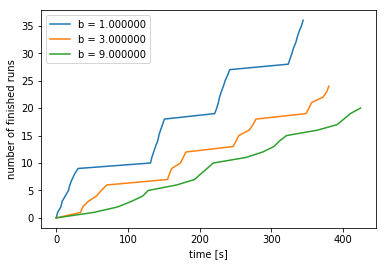

In [25]:
# START TODO ##################
import warnings

hpvis.finished_runs_over_time(all_runs)
warnings.filterwarnings("ignore")

Evaluating configurations on lower budgets doesn't make sense - even if they are faster - if the performance ranking isn't consistent from low to high budget. This means, that the loss rankings for configurations should correlate. In simplified terms: The best configuration after one epoch should also be the best after nine epochs, the second best should stay the second best and so on.

**Task:** Plot correlations of rankings across budgets. Are the correlations high enough?

**Answer:**

It depends on the budget. The color and variable "spearman" represent the correlation. The closer is, the more correlation across budgets. A larger correlation should mean a lower loss.

In our case, budget (9) and (1) have negative correlation between them. For the others, this correlation increases.

17:17:05 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fc9c1649dd8>
17:17:05 Using auto colorbar locator on colorbar
17:17:05 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fc9c1649dd8>
17:17:05 Setting pcolormesh


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc9c168ac88>)

17:17:05 update_title_pos
17:17:05 not adjusting title pos because title was already placed manually: 1.050000
17:17:05 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/eduardoalvarado/py_35_env/lib/python3.5/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
17:17:05 update_title_pos
17:17:05 update_title_pos
17:17:05 title position was updated manually, not adjusting
17:17:05 update_title_pos
17:17:05 update_title_pos
17:17:05 title position was updated manually, not adjusting
17:17:05 update_title_pos
17:17:05 update_title_pos
17:17:05 title position was updated manually, not adjusting
17:17:05 update_title_pos
17:17:05 update_title_pos
17:17:05 title position was updated manually, not adjusting
17:17:05 update_title_pos


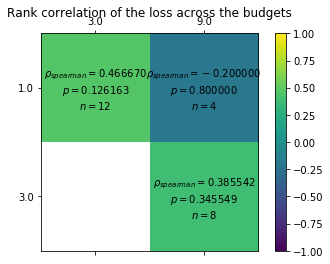

In [26]:
# START TODO ##################

hpvis.correlation_across_budgets(result)

We usually assume, that training on a higher budget (number of epochs) and sampling more configurations can lead to better results. Let's check this.

**Task:** Plot the losses over time. Do our assumptions hold true? Why?

**Answer:** 

The different lines represent the budgets. A larger budget has lower loss. Nevertheless, and regardless the outliers, our three budgets have losses lower 0.2.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc9c155f940>)

17:17:18 update_title_pos
17:17:18 update_title_pos
17:17:18 update_title_pos
17:17:18 update_title_pos
17:17:18 update_title_pos


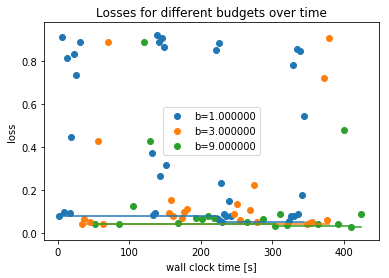

In [27]:
# START TODO ##################

hpvis.losses_over_time(all_runs)


Remember that BOHB uses a model after some time to improve the configuation sampling. We can check, if the BO-sampled configurations work better than the random-sampled.

**Task:** Plot loss histograms for all budgets only with BO-sampled and only with random-sampled configurations (6 histograms). Is the BO-sampling useful?

**Answer:**

Yes! In the subplots we can observe the following:

In the case of the low budget (1), using random search, there is a large frequency of high losses during the  process. Instead, by using BOHB those large losses almost dissapear.

In a general way, increasing budgets reduce the amount of large losses. 

This can be noticed in the budget (9) with BOHB, where the frequency of high losses decreases and only almost remain few small losses. For Random Search, to increase the budget doesn't provide any special advantage with respect to the medium-high losses.

Therefore we can affirm that BOHB improves the efficiency for sampling.

(<Figure size 432x288 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc9c152af60>,
       dtype=object))

17:17:22 update_title_pos
17:17:22 update_title_pos
17:17:22 update_title_pos
17:17:22 update_title_pos
17:17:22 update_title_pos
17:17:22 update_title_pos
17:17:22 update_title_pos
17:17:22 update_title_pos
17:17:22 update_title_pos
17:17:22 update_title_pos
17:17:22 update_title_pos
17:17:22 update_title_pos
17:17:22 update_title_pos
17:17:22 update_title_pos
17:17:22 update_title_pos
17:17:22 update_title_pos
17:17:22 update_title_pos
17:17:22 update_title_pos
17:17:23 update_title_pos
17:17:23 update_title_pos
17:17:23 update_title_pos
17:17:23 update_title_pos
17:17:23 update_title_pos
17:17:23 update_title_pos
17:17:23 update_title_pos
17:17:23 update_title_pos
17:17:23 update_title_pos
17:17:23 update_title_pos
17:17:23 update_title_pos
17:17:23 update_title_pos


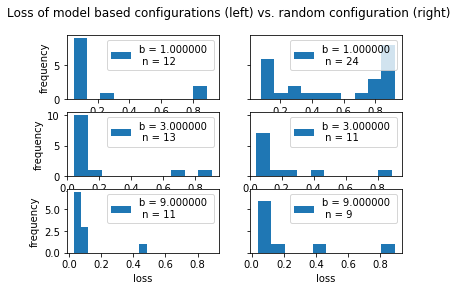

In [28]:
# START TODO ##################

hpvis.performance_histogram_model_vs_random(all_runs, id2conf)


### Your Feedback on Exercise 6.2

More difficult than the last part. We dedicate more time for this than expected. Although the beginning is similar, the debug and reasoning for BOHB requires a little bit of time to understand. Cool exercise! :)